## CS680 Introduction to Machine Learning
### Fall 2022 - Final Project
---
By _Yujia Zheng (20789867)_

## BERT

In [1]:
# Import packages.
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

!pip install transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from torch.utils.data import RandomSampler, SequentialSampler, DataLoader
from torch.nn.utils import clip_grad_norm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

from transformers import BertForSequenceClassification
from transformers import AdamW,get_linear_schedule_with_warmup

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 7.5 MB/s 
     |████████████████████████████████| 7.6 MB 59.2 MB/s 
     |████████████████████████████████| 182 kB 55.7 MB/s 


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### BERT Data Split and Manipulation



In [3]:
# Read in and organize the training and test set.
IMDB = pd.read_csv('https://git.uwaterloo.ca/y326zhen/cs680_project/-/raw/main/IMDB.csv')
IMDB.head(5)

Unnamed: 0                                               text  id  label
0           0  I went and saw this movie last night after bei...   0      1
1           1  Actor turned director Bill Paxton follows up h...   1      1
2           2  As a recreational golfer with some knowledge o...   2      1
3           3  I saw this film in a sneak preview, and it is ...   3      1
4           4  Bill Paxton has taken the true story of the 19...   4      1

In [4]:
# Keep only the text and label columns.
IMDB = IMDB[['text', 'label']]
IMDB.head(5)

text  label
0  I went and saw this movie last night after bei...      1
1  Actor turned director Bill Paxton follows up h...      1
2  As a recreational golfer with some knowledge o...      1
3  I saw this film in a sneak preview, and it is ...      1
4  Bill Paxton has taken the true story of the 19...      1

In [5]:
# Split the training and test set.
train_X, test_X, train_y, test_y = train_test_split(IMDB.index.values,
                                                    IMDB.label.values,
                                                    test_size = 0.2,
                                                    random_state=999,
                                                    stratify = IMDB.label.values)

print('Size of training set:', train_y.shape[0])
print('Size of test set:', test_y.shape[0])

Size of training set: 20000
Size of test set: 5000


In [6]:
# Create a new column indicating whether each datapoint is in training or test set.
IMDB.loc[train_X,'set'] = 'train'
IMDB.loc[test_X,'set'] = 'test'
IMDB.head(10)

text  label    set
0  I went and saw this movie last night after bei...      1  train
1  Actor turned director Bill Paxton follows up h...      1  train
2  As a recreational golfer with some knowledge o...      1  train
3  I saw this film in a sneak preview, and it is ...      1  train
4  Bill Paxton has taken the true story of the 19...      1  train
5  I saw this film on September 1st, 2005 in Indi...      1  train
6  Maybe I'm reading into this too much, but I wo...      1  train
7  I felt this film did have many good qualities....      1  train
8  This movie is amazing because the fact that th...      1   test
9  "Quitting" may be as much about exiting a pre-...      1  train

### BERT Model Embedding

In [7]:
# BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
# Example of using tokenizer.
tokenizer.tokenize('Hello world this is a machine learning course project.')

['hello',
 'world',
 'this',
 'is',
 'a',
 'machine',
 'learning',
 'course',
 'project',
 '.']

In [9]:
# Build the training and test encoders.
%%time
train_encoder = tokenizer.batch_encode_plus(IMDB[IMDB['set']=='train'].text.values,
                                            add_special_tokens = True,
                                            pad_to_max_length = True,
                                            max_length = 256,
                                            return_tensors = 'pt')

test_encoder = tokenizer.batch_encode_plus(IMDB[IMDB['set']=='test'].text.values,
                                           add_special_tokens = True,
                                           pad_to_max_length = True,
                                           max_length = 256,
                                           return_tensors = 'pt')

# input_ids: List of token ids to be fed to a model.
train_input_ids = train_encoder['input_ids']
# attention_masks: List of indices specifying which tokens should be attended to by the model .
train_attention_masks = train_encoder["attention_mask"]
train_labels = torch.tensor(IMDB[IMDB['set']=='train'].label.values)

test_input_ids = test_encoder['input_ids']
attention_masks_test = test_encoder["attention_mask"]
test_labels = torch.tensor(IMDB[IMDB['set']=='test'].label.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


CPU times: user 2min 21s, sys: 688 ms, total: 2min 22s
Wall time: 2min 35s


In [10]:
# Make a tensor dataset consisting of input_ids, attention_masks and labels.
train_data = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_data = TensorDataset(test_input_ids, attention_masks_test, test_labels)

### BERT Model Training and Evaluation

In [11]:
# Helper functions for evaluating model performance.
def acc_score(preds, labels):
  
    preds_flatten = np.argmax(preds, axis=1).flatten()
    labels_flatten = labels.flatten()
    return accuracy_score(labels_flatten, preds_flatten)

def acc_per_class(preds, labels):

    preds_flatten = np.argmax(preds, axis=1).flatten()
    labels_flatten = labels.flatten()

    for label in np.unique(labels_flatten):
        preds_l = preds_flatten[labels_flatten == label]
        labels_l = labels_flatten[labels_flatten == label]
        print(f"Class:{label}")
        print(f"Accuracy:{len(preds_l[preds_l==label])}/{len(labels_l)}\n")

In [12]:
# Create the training and test data loaders.
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size = 16
)

test_dataloader = DataLoader(
    test_data,
    sampler=RandomSampler(test_data),
    batch_size = 16
)

In [13]:
# Define the BERT model, optimizer, number of epochs and scheduler.
IMDB_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                          num_labels = 2,
                                                          output_attentions = False,
                                                          output_hidden_states =  False)
IMDB_bert.to(device)

optimizer = AdamW(IMDB_bert.parameters(), lr = 1e-4, eps = 1e-8)
num_epoch = 3
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = len(train_dataloader)*num_epoch)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [15]:
def evaluate(model=IMDB_bert, test_dataloader=test_dataloader):
  
    model.eval()
    test_loss = 0
    test_losses, preds, true_labels, test_acc = [], [], [], []

    for batch_data in tqdm(test_dataloader):
        
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch_data)
        inputs = {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

        with torch.no_grad():
            outputs = model(**inputs)

        batch_loss = outputs[0]
        test_loss += batch_loss.item()
        test_losses.append(test_loss)
        batch_logits = outputs[1]
        
        batch_logits = batch_logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        preds.append(batch_logits)
        true_labels.append(label_ids)

        np_preds = np.concatenate(preds, axis=0)
        np_true_labels = np.concatenate(true_labels, axis=0)
        test_acc.append(acc_score(np_preds, np_true_labels))
        
    return test_losses, preds, true_labels, test_acc

In [16]:
%%time
e_train_losses, e_test_losses, e_test_accs = [], [], []

for epoch in range(1, num_epoch+1):

    IMDB_bert.train()
    train_loss = 0
    train_losses = []
    progress = tqdm(train_dataloader, 
                    desc = "Epoch: {:1d}".format(epoch), 
                    leave = False, 
                    disable = False)

    for batch_data in progress:

        IMDB_bert.zero_grad()
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch_data)
        inputs = {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }
        outputs = IMDB_bert(**inputs)
        batch_loss = outputs[0]
        train_loss += batch_loss.item()
        train_losses.append(train_loss)
        batch_loss.backward()
        
        clip_grad_norm(IMDB_bert.parameters(),1.0)
        optimizer.step()

        scheduler.step()
        progress.set_postfix({'training_loss':'{:.3f}'.format(batch_loss.item()/len(batch_data))})

    tqdm.write(f'\nEpoch {epoch}')
    tqdm.write(f'Training Loss: {train_losses[-1]}')

    # The average test loss, predictions, and the true labels
    test_losses, preds, true_labels, test_acc = evaluate(IMDB_bert, test_dataloader)
    e_train_losses.append(train_losses)
    e_test_losses.append(test_losses)
    e_test_accs.append(test_acc)

    tqdm.write(f'Test Loss:{test_losses[-1]}\nTest Accuracy:{test_acc[-1]}') #\n Test F1 Score:{test_score}

Epoch: 1:   0%|          | 0/1250 [00:00<?, ?it/s]

<timed exec>:28: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.



Epoch 1
Training Loss: 497.20440869033337


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss:100.59882983192801
Test Accuracy:0.8866


Epoch: 2:   0%|          | 0/1250 [00:00<?, ?it/s]

<timed exec>:28: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.



Epoch 2
Training Loss: 296.72041721781716


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss:78.42340551503003
Test Accuracy:0.9056


Epoch: 3:   0%|          | 0/1250 [00:00<?, ?it/s]

<timed exec>:28: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.



Epoch 3
Training Loss: 162.51360335666686


  0%|          | 0/313 [00:00<?, ?it/s]

Test Loss:106.67984717804939
Test Accuracy:0.913
CPU times: user 45min 57s, sys: 15.3 s, total: 46min 12s
Wall time: 46min 29s


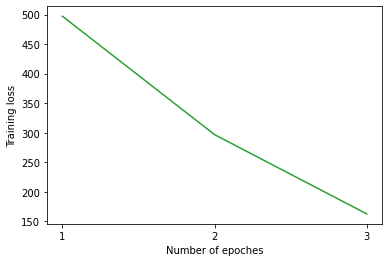

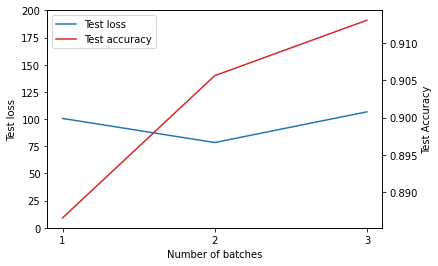

In [28]:
x = ['1', '2', '3']
epoch_training_loss = [e_train_losses[0][-1], e_train_losses[1][-1], e_train_losses[2][-1]]
plt.plot(x, epoch_training_loss, color='tab:green')
plt.xlabel('Number of epoches')
plt.ylabel('Training loss')
plt.show()

epoch_test_loss = [e_test_losses[0][-1], e_test_losses[1][-1], e_test_losses[2][-1]]
epoch_test_acc = [e_test_accs[0][-1], e_test_accs[1][-1], e_test_accs[2][-1]]

fig, ax = plt.subplots()
twin = ax.twinx()
p1, = ax.plot(x, epoch_test_loss, color='tab:blue', label='Test loss')
p2, = twin.plot(x, epoch_test_acc, color='tab:red', label='Test accuracy')

ax.set_xlabel('Number of batches')
ax.set_ylabel('Test loss')
ax.set_ylim((0, 200))
twin.set_ylabel('Test Accuracy')

ax.legend(loc='upper left', handles=[p1, p2])

## Classification Using Soft-Margin SVM

In [2]:
# Import additional packages.
import re
import time
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import hinge_loss

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### SVM Model Embedding

In [3]:
IMDB_svm = pd.read_csv('https://git.uwaterloo.ca/y326zhen/cs680_project/-/raw/main/IMDB.csv')
IMDB_svm = IMDB_svm[['text', 'label']]
IMDB_svm.head(10)

text  label
0  I went and saw this movie last night after bei...      1
1  Actor turned director Bill Paxton follows up h...      1
2  As a recreational golfer with some knowledge o...      1
3  I saw this film in a sneak preview, and it is ...      1
4  Bill Paxton has taken the true story of the 19...      1
5  I saw this film on September 1st, 2005 in Indi...      1
6  Maybe I'm reading into this too much, but I wo...      1
7  I felt this film did have many good qualities....      1
8  This movie is amazing because the fact that th...      1
9  "Quitting" may be as much about exiting a pre-...      1

In [4]:
text_svm = []
lemma = WordNetLemmatizer()
swords = stopwords.words('english')
for text in IMDB_svm['text']:
    # Cleaning everything except alphabetical and numerical characters
    text = re.sub("[^a-zA-Z0-9]"," ",text)
    # Tokenizing and lemmatizing
    text = nltk.word_tokenize(text.lower())
    text = [lemma.lemmatize(word) for word in text]
    # Removing stopwords
    text = [word for word in text if word not in swords]
    # Joining
    text = " ".join(text)
    text_svm.append(text)

In [5]:
# Take a look at the text pre-processing result.
text_svm[0]

'went saw movie last night coaxed friend mine admit wa reluctant see knew ashton kutcher wa able comedy wa wrong kutcher played character jake fischer well kevin costner played ben randall professionalism sign good movie toy emotion one exactly entire theater wa sold wa overcome laughter first half movie moved tear second half exiting theater saw many woman tear many full grown men well trying desperately let anyone see cry movie wa great suggest go see judge'

In [6]:
# Bag of Words embedding
vectorizer = CountVectorizer(max_features=10000)
BoW = vectorizer.fit_transform(text_svm)

### SVM Data Split

In [7]:
# Split the training and test set.
train_X, test_X, train_y, test_y = train_test_split(BoW,
                                                    IMDB_svm['label'],
                                                    test_size = 0.2,
                                                    random_state=999)
print('Size of training set:', train_y.shape[0])
print('Size of test set:', test_y.shape[0])
print('Size of embedding features:', train_X.shape[1])

Size of training set: 20000
Size of test set: 5000
Size of embedding features: 10000


### SVM Model Training and Evaluation

In [8]:
%%time
IMDB_svm = svm.SVC()
IMDB_svm.fit(train_X, train_y)

CPU times: user 9min 10s, sys: 906 ms, total: 9min 11s
Wall time: 9min 43s


SVC()

In [9]:
%%time
train_preds_svm = IMDB_svm.predict(train_X)
print('Training accuracy:', accuracy_score(train_y, train_preds_svm))
print('Training loss:', hinge_loss(train_y, train_preds_svm))

Training accuracy: 0.9618
Training loss: 0.5416
CPU times: user 4min 17s, sys: 174 ms, total: 4min 17s
Wall time: 4min 16s


In [10]:
%%time
test_preds_svm = IMDB_svm.predict(test_X)
print('Test accuracy:', accuracy_score(test_y, test_preds_svm))
print('Test loss:', hinge_loss(test_y, test_preds_svm))

Test accuracy: 0.885
Test loss: 0.6014
CPU times: user 1min 4s, sys: 57 ms, total: 1min 4s
Wall time: 1min 4s
